Handout: Explaining Clusters - example
    <ol>
    <li>Goal</li>
    You clustered your dataset (e.g. patient samples). Now: which features define each cluster?
    <li>Workflow</li>
        <ol>
        <li>Summarize features by cluster</li>
            <ul>
                <li>Continuous: mean, std, median.</li>
            </ul>
            <ul>
                <li>Binary: counts, proportions.</li>
            </ul>
        <li>Test differences</li>
            <ul>
                <li>Continuous → ANOVA/Kruskal-Wallis + Cohen’s d effect size.</li>
            </ul>
            <ul>
                <li>Binary → Chi-square/Fisher + difference in proportions.</li>
            </ul>
            <ul>
                <li>Adjust p-values (Benjamini–Hochberg).</li>
            </ul>
        <li>Multivariate check</li>
            <ul>
                <li>Train a Random Forest (or logistic regression) to predict cluster labels.</li>
            </ul>
            <ul>
                <li>Look at feature importance (permutation / SHAP).</li>
            </ul>
        <li>Interpret clusters</li>
            <ul>
                <li>Combine univariate + multivariate evidence.</li>
            </ul>
            <ul>
                <li>Example: Cluster 2 = high BMI, high diabetes prevalence, older patients.</li>
            </ul>
        <li>Visualize</li>
            <ul>
                <li>Heatmap of feature means per cluster (or Heatmap of sample features, after reordering samples
            by cluster).</li>
            </ul>
            <ul>
                <li>Boxplots for key continuous vars</li>
            </ul>
            <ul>
                <li>Bar plots for binary vars.</li>
            </ul>
            <ul>
                <li>UMAP/t-SNE scatter colored by features.</li>
            </ul>
        </ol>
    </ol>

In [ ]:
# Manipolations data
import pandas as pd
import numpy as np

# Clustering e ML

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

# Statistics
from scipy.stats import f_oneway, kruskal, chi2_contingency
from statsmodels.stats.multitest import multipletests

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns
import shap


In [150]:
df = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

Normalization and clustering

In [ ]:
# Let's separate the features
X = df.copy()

continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

# Standardization
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Clustering (esempio con K-Means)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adding clusters to the dataframe
df['cluster'] = clusters

X_scaled.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  0.636364      0.0                  0.071319       0.0           0.090909   
1  0.272727      0.0                  1.000000       0.0           0.363636   
2  0.454545      0.0                  0.015693       0.0           0.090909   
3  0.181818      1.0                  0.011227       0.0           0.090909   
4  0.454545      1.0                  0.017479       1.0           0.090909   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                  1.0   0.290823          0.157303      0.485714  1.0   
1                  0.0   0.288833          0.067416      0.657143  1.0   
2                  0.0   0.165960          0.089888      0.457143  1.0   
3                  0.0   0.224148          0.157303      0.685714  1.0   
4                  0.0   0.365984          0.247191      0.085714  0.0   

   smoking      time  DEATH_EVENT  
0      0.0  0.000000          1.0  
1      0.0  0.007117          1.0  
2      1.0  0.010676          1.0  
3      0.0  0.010676          1.0  
4      0.0  0.014235          1.0

Univariate analysis: differences between clusters

Continuous variables → ANOVA / Kruskal

In [ ]:
#continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
results = []

for var in continuous_vars:
    groups = [df[df['cluster'] == c][var] for c in df['cluster'].unique()]
    stat, p = f_oneway(*groups)  # oppure kruskal(*groups)
    results.append({'variable': var, 'p_value': p})

# Correction p-value (Benjamini–Hochberg)
res_df = pd.DataFrame(results)
res_df.sort_values('p_value')

variable       p_value
6                      time  8.171895e-16
0                       age  4.329118e-06
2         ejection_fraction  3.953580e-05
4          serum_creatinine  6.744797e-05
5              serum_sodium  2.003730e-02
3                 platelets  1.260529e-01
1  creatinine_phosphokinase  6.938661e-01

Binary variables → Chi-square

In [153]:
#binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

chi_results = []
for var in binary_vars:
    contingency = pd.crosstab(df[var], df['cluster'])
    chi2, p, _, _ = chi2_contingency(contingency)
    chi_results.append({'variable': var, 'p_value': p})

chi_df = pd.DataFrame(chi_results)
chi_df.sort_values('p_value')


variable       p_value
5          DEATH_EVENT  2.061742e-50
3                  sex  3.173357e-30
4              smoking  1.766498e-24
1             diabetes  3.174791e-16
0              anaemia  2.155811e-01
2  high_blood_pressure  6.273104e-01

Multivariate analysis (Random Forest to understand feature importance)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, clusters, test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

print(classification_report(y_test, rf.predict(X_test)))

# Importance con permutation importance
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)
importance_df.head()

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.91      0.94      0.93        34
           2       0.93      0.93      0.93        30

    accuracy                           0.94        90
   macro avg       0.95      0.95      0.95        90
weighted avg       0.95      0.94      0.94        90



feature  importance
12  DEATH_EVENT    0.378889
9           sex    0.184444
3      diabetes    0.124444
10      smoking    0.091111
1       anaemia    0.000000

<b>Visualization</b>

Heatmap of cluster averages

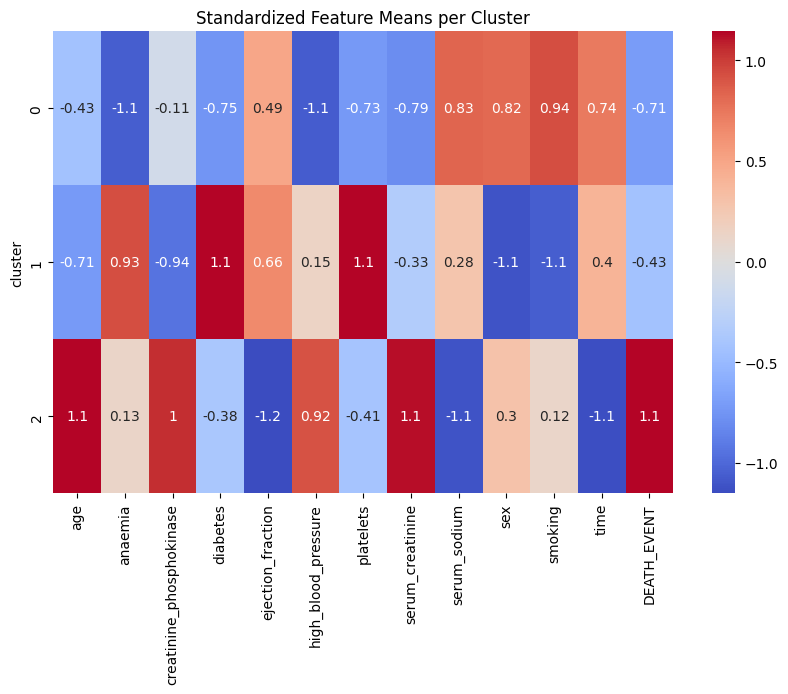

In [156]:
# Standardize the feature values (z-scores)
standardized_means = df.groupby('cluster').mean()
standardized_means = (standardized_means - standardized_means.mean()) / standardized_means.std()

# Plot the standardized heatmap
plt.figure(figsize=(10,6))
sns.heatmap(standardized_means, cmap='coolwarm', annot=True)
plt.title("Standardized Feature Means per Cluster")
plt.show()

Boxplots with continuous variables

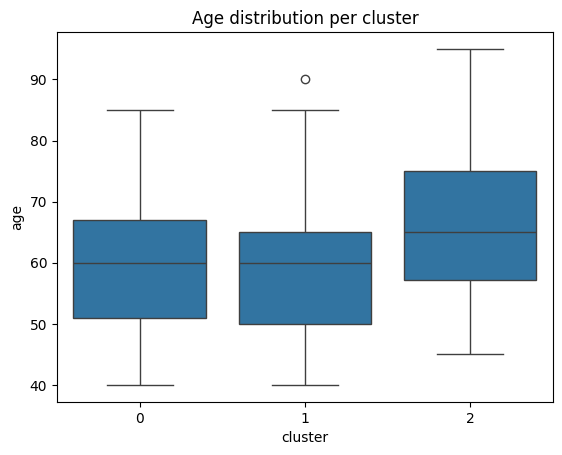

In [157]:
sns.boxplot(data=df, x='cluster', y='age')
plt.title('Age distribution per cluster')
plt.show()


Barplot for binary variables

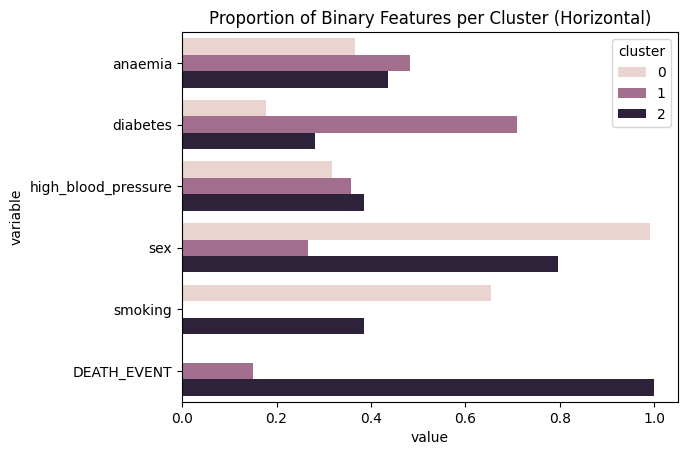

In [160]:
# Calculate the mean proportions of binary features by cluster
binary_means = df.groupby('cluster')[binary_vars].mean().reset_index()

# Melt the DataFrame to long format for seaborn compatibility
binary_means_melted = binary_means.melt(id_vars='cluster', var_name='variable', value_name='value')

# Plot the horizontal barplot
sns.barplot(data=binary_means_melted, x='value', y='variable', hue='cluster', orient='h')
plt.title('Proportion of Binary Features per Cluster (Horizontal)')
plt.show()


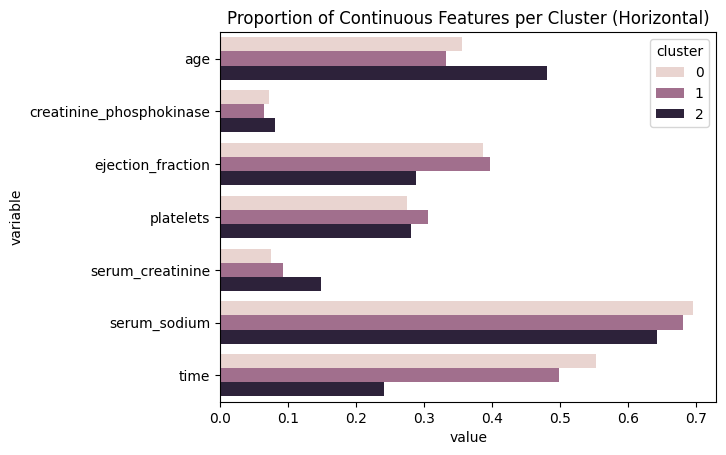

In [161]:
# Calculate the mean proportions of binary features by cluster
X_scaled['cluster'] = clusters
continuous_means = X_scaled.groupby('cluster')[continuous_vars].mean().reset_index()

# Melt the DataFrame to long format for seaborn compatibility
continuous_means_melted = continuous_means.melt(id_vars='cluster', var_name='variable', value_name='value')

# Plot the horizontal barplot
sns.barplot(data=continuous_means_melted, x='value', y='variable', hue='cluster', orient='h')
plt.title('Proportion of Continuous Features per Cluster (Horizontal)')
plt.show()
